In [1]:
import random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.decomposition import PCA
from pymutspec.draw import plot_mutspec12
from scipy.stats import uniform
from Bio import SeqIO


from utils import (
    get_equilibrium_freqs_rnd, get_random_spectra, get_equilibrium_freqs, 
    transitions, transversions, prepare_exp_aa_subst, alphabet, amino_acid_codes,
)
# from psynlig import pca_2d_scores

In [2]:
my_palette = sns.diverging_palette(12, 255, s=100, sep=50, as_cmap=True)
matplotlib.colormaps.register(my_palette, name="RedBlue3")

## Load rdrp freqs

In [3]:
data = []
for rec in SeqIO.parse("data/rdrp1.fa", "fasta"):
    seq = str(rec.seq)
    aa_counts = dict(Counter(seq))
    aa_counts['species'] = rec.id
    data.append(aa_counts)

obs_freqs_rdrp = pd.DataFrame(data).set_index('species')\
    .rename(columns=amino_acid_codes).fillna(0.)
rdrp_sizes = obs_freqs_rdrp.sum(axis=1)
obs_freqs_rdrp = obs_freqs_rdrp / rdrp_sizes.values[:, None]
obs_freqs_rdrp = obs_freqs_rdrp[rdrp_sizes > 400]
obs_freqs_rdrp

,Asn,Ala,Pro,Ser,Glu,Leu,Cys,Phe,Lys,Tyr,...,Gly,Ile,Thr,Gln,Asp,Trp,Met,X,B,J
species,,,,,,,,,,,,,,,,,,,,,
dupl.Aspiviridae-1.culex_tritaeniorhynchus_aspiviridae_related_virus:BBQ04833,0.063091,0.050473,0.029968,0.069401,0.056782,0.110410,0.012618,0.031546,0.063091,0.055205,...,0.053628,0.066246,0.039432,0.045741,0.061514,0.012618,0.037855,0.0,0.0,0.0
dupl.Birnaviridae-1.alternaria_alternata_botybirnavirus_1:QBZ78320,0.035573,0.081028,0.011858,0.063241,0.094862,0.071146,0.015810,0.027668,0.077075,0.051383,...,0.079051,0.055336,0.043478,0.047431,0.041502,0.019763,0.031621,0.0,0.0,0.0
dupl.Birnaviridae-1.botrytis_cinerea_botybirnavirus_1:AYX40886,0.039526,0.059289,0.033597,0.073123,0.088933,0.090909,0.015810,0.041502,0.073123,0.049407,...,0.065217,0.035573,0.053360,0.047431,0.045455,0.017787,0.029644,0.0,0.0,0.0
dupl.Birnaviridae-1.botrytis_porri_botybirnavirus_1:YP_006390636,0.037475,0.082840,0.017751,0.065089,0.078895,0.078895,0.015779,0.025641,0.061144,0.045365,...,0.080868,0.049310,0.047337,0.049310,0.045365,0.019724,0.035503,0.0,0.0,0.0
dupl.Birnaviridae-1.ipomoea_aquatica_botybirnavirus:QKI28860,0.035573,0.079051,0.031621,0.063241,0.081028,0.090909,0.017787,0.039526,0.069170,0.045455,...,0.055336,0.031621,0.065217,0.035573,0.045455,0.019763,0.033597,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rdrp.Unc817.wolf_4586:yaOV316orf3967,0.027422,0.093236,0.051188,0.067642,0.065814,0.085923,0.027422,0.043876,0.047532,0.032907,...,0.054845,0.045704,0.058501,0.043876,0.049360,0.010969,0.029250,0.0,0.0,0.0
rdrp.Unc819.wolf_4583:yaOV313orf3435,0.037997,0.055268,0.043178,0.069085,0.053541,0.082902,0.027634,0.063903,0.055268,0.044905,...,0.056995,0.060449,0.055268,0.044905,0.063903,0.013817,0.020725,0.0,0.0,0.0
rdrp.Unc821.wolf_4581:yaOV311orf2997,0.027833,0.073559,0.073559,0.065606,0.063618,0.091451,0.011928,0.023857,0.011928,0.035785,...,0.061630,0.039761,0.063618,0.027833,0.085487,0.011928,0.013917,0.0,0.0,0.0


Text(0, 0.5, 'Number of species')

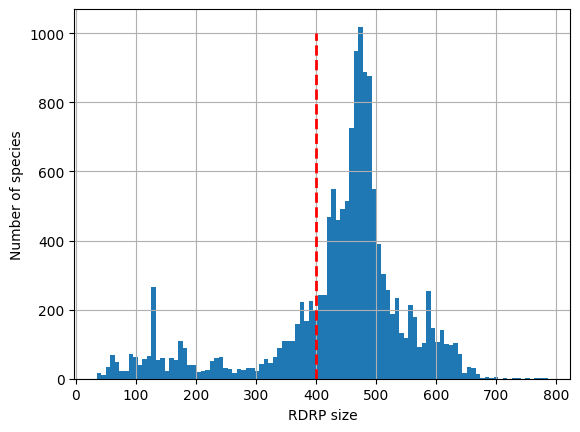

In [4]:
rdrp_sizes.hist(bins=100)
plt.vlines(400, 0, 1000, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("RDRP size")
plt.ylabel("Number of species")


## Random spectra consequenses

### Tests

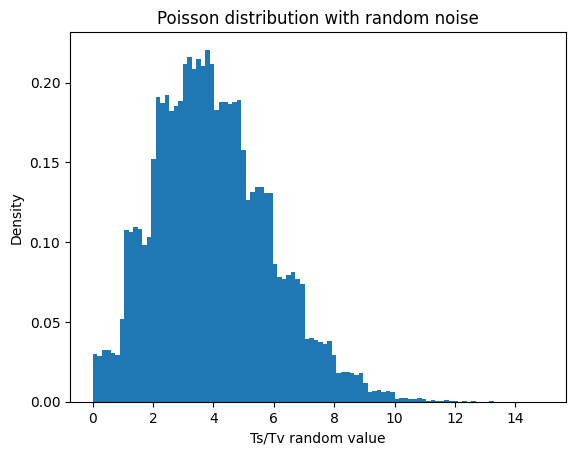

In [5]:
tstv_ratios = np.random.poisson(3.5, 100000) + np.random.random(100000)
plt.hist(tstv_ratios, 100, density=True)
plt.title('Poisson distribution with random noise')
plt.xlabel('Ts/Tv random value')
plt.ylabel('Density')
plt.show()

In [9]:
np.repeat([1,2], 2)

array([1, 1, 2, 2])

In [74]:
p, p * [1,2,3,4,5,6]

(array([0.42377576, 0.35759614, 0.92607572, 0.59434728, 0.96483095,
        0.2088399 ]),
 array([0.42377576, 0.71519228, 2.77822716, 2.37738913, 4.82415477,
        1.25303939]))

In [79]:
p

array([0.09644329, 0.25960084, 0.32858186, 0.9341793 , 0.36482852,
       0.85394041])

In [91]:
p = np.random.rand(6)
_tstv1 = (p[1] + p[3]) / (p.sum() - p[1] - p[3])
p *= [1,2/_tstv1,1,2/_tstv1,1,1]
_tstv2 = (p[1] + p[3]) / (p.sum() - p[1] - p[3])

print(_tstv1, _tstv2)

0.5745256070895101 1.9999999999999996


In [53]:
p

array([0.01059512, 0.9634007 , 0.67984578, 0.39831444, 0.39523748,
       0.51439138])

Text(0.5, 1.0, 'random symmetrical spectrum')

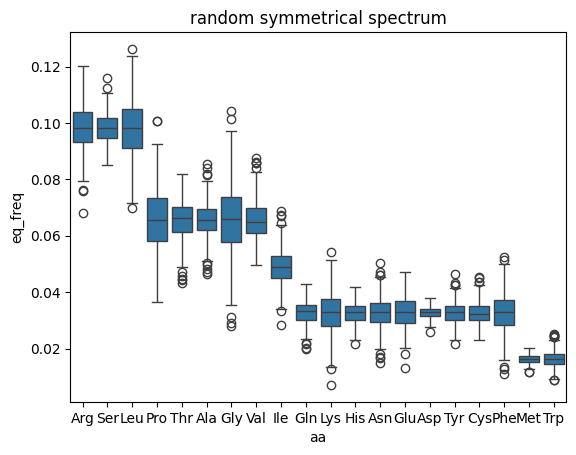

In [97]:
da = []
for i in range(500):
    p = np.random.rand(6)
    # _tstv1 = (p[1] + p[3]) / (p.sum() - p[1] - p[3])
    # exp_tstv = 3
    # p *= [1,exp_tstv/_tstv1,1,exp_tstv/_tstv1,1,1]
    p = np.repeat(p, 2)
    p /= p.sum()

    rnd_sp = pd.DataFrame({
        'Mut': 'A>C C>A A>G G>A A>T T>A T>C C>T T>G G>T C>G G>C'.split(),
        'MutSpec': p,
    })
    _, rnd_eq_aa_freqs = get_equilibrium_freqs(rnd_sp, rate_col='MutSpec', gc=1)
    rnd_eq_aa_freqs['i'] = i
    da.append(rnd_eq_aa_freqs)
dadf1 = pd.concat(da, ignore_index=True)

sns.boxplot(dadf1, x='aa', y='eq_freq')
plt.title('random symmetrical spectrum')

Text(0.5, 1.0, 'random spectrum')

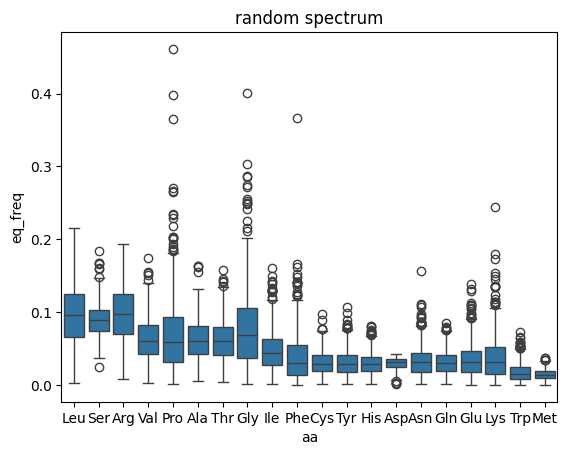

In [44]:
da = []
for i in range(500):
    rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=tstv_ratios[i])
    rnd_eq_aa_freqs['i'] = i
    da.append(rnd_eq_aa_freqs)
dadf2 = pd.concat(da, ignore_index=True)

sns.boxplot(dadf2, x='aa', y='eq_freq', order=dadf1.aa.unique())
plt.title('random spectrum', )

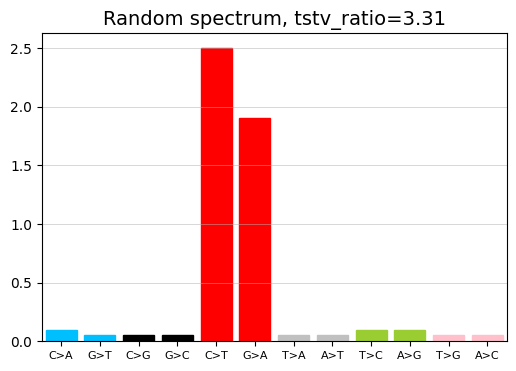

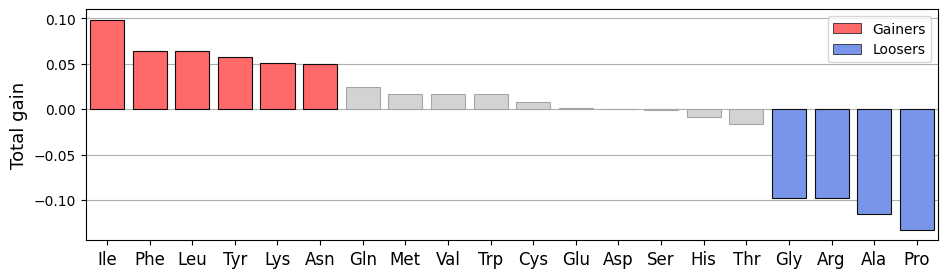

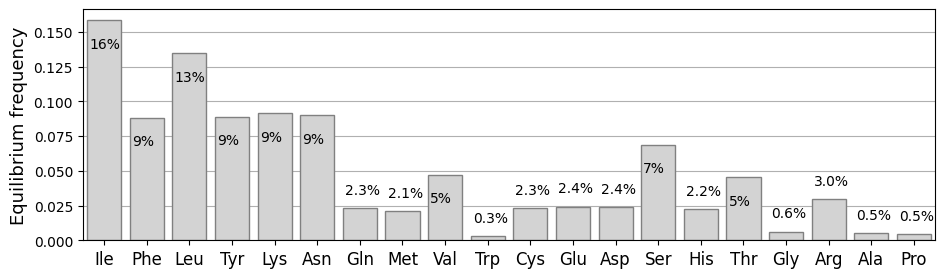

In [ ]:
i = 102
tstv_ratio = 4
# rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=tstv_ratio)
rnd_sp = pd.DataFrame({
    'Mut': 'A>C C>A A>G G>A A>T T>A T>C C>T T>G G>T C>G G>C'.split(),
    'MutSpec': np.array([
        0.05, 0.1, 0.1, 1.9, 0.05, 0.05, 0.1, 2.5, 0.05, 0.05, 0.05, 0.05,
    ]),
})
_, rnd_eq_aa_freqs = get_equilibrium_freqs(rnd_sp, rate_col='MutSpec', gc=1)

plot_mutspec12(rnd_sp, title=f'Random spectrum, tstv_ratio={tstv_ratio:.2f}')

_, exp_aa_subst_matrix = prepare_exp_aa_subst(rnd_sp, 'MutSpec', gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow, x='aa', y='Flow', color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right')

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Total gain', fontsize=13)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.xticks(fontsize=12)
plt.show()


plt.figure(figsize=(11, 3))
ax=sns.barplot(rnd_eq_aa_freqs, x='aa', y='eq_freq', order=flow.aa, color='lightgray', edgecolor='gray')

for i, aa in enumerate(flow.aa.values):
    f = rnd_eq_aa_freqs.query('aa == @aa').eq_freq.item()
    x = i-0.35
    if f < 0.03:
        lbl = f"{f*100:.1f}%" 
        y = f + 0.01
    else:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [13]:
from warnings import filterwarnings
filterwarnings("ignore",)

In [2]:
def get_looser_gainer_score(exp_aa_subst_matrix):
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

    _freqs_to = (freqs_to / freqs_to.sum()).copy()
    _freqs_from = (freqs_from / freqs_from.sum()).copy()
    _freqs_to.index.name = 'aa'
    _freqs_from.index.name = 'aa'

    flow = _freqs_to - _freqs_from
    return flow

In [ ]:
nsamples = 10
tstv_ratios = np.random.poisson(3.5, nsamples) + np.random.random(nsamples)

random_eq_freqs = []
random_ms = []
looser_gainer_score = []
for replic, x in enumerate(tstv_ratios, 1):
    cur_tstv_ratio = round(x, 1)
    # cur_tstv_ratio = None
    rnd_sp, (_, rnd_eq_aa_freqs) = get_equilibrium_freqs_rnd(tstv_ratio=cur_tstv_ratio)
    rnd_sp = rnd_sp.assign(tstv_ratio=cur_tstv_ratio, replic=replic)

    _, exp_aa_subst_matrix = prepare_exp_aa_subst(rnd_sp, 'MutSpec')
    cur_looser_gainer_score = get_looser_gainer_score(exp_aa_subst_matrix)\
        .rename('flow_score').reset_index().assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    looser_gainer_score.append(cur_looser_gainer_score)
    
    rnd_eq_aa_freqs = rnd_eq_aa_freqs.assign(tstv_ratio=cur_tstv_ratio, replic=replic)
    # one_sample = pd.concat([
    #     rnd_sp.pivot(index='tstv_ratio', columns='Mut', values='MutSpec'),
    #     rnd_eq_aa_freqs.pivot(index='tstv_ratio', columns='aa', values='eq_freq')
    # ], axis=1)
    random_eq_freqs.append(rnd_eq_aa_freqs)
    random_ms.append(rnd_sp)

random_eq_freqs = pd.concat(random_eq_freqs, ignore_index=False)
random_ms = pd.concat(random_ms, ignore_index=False)
looser_gainer_score = pd.concat(looser_gainer_score, ignore_index=False)

### Precalculated

In [5]:
random_eq_freqs = pd.read_csv('data/random_eq_aa_freqs.csv', index_col=0)
random_ms = pd.read_csv('data/random_spectra.csv')
random_ms_wide = random_ms.pivot(index=['replica', 'tstv_ratio'], columns='Mut', values='MutSpec')

In [4]:
random_eq_freqs.head()

,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
replic,,,,,,,,,,,,,,,,,,,,
0,0.025452,0.027581,0.014280,0.008083,0.027903,0.009376,0.002129,0.005781,0.035589,0.057589,0.200058,0.003762,0.004694,0.170178,0.112064,0.163308,0.044965,0.002657,0.049296,0.035254
1,0.098495,0.102412,0.001884,0.009090,0.054067,0.006146,0.003917,0.062762,0.014266,0.012034,0.150123,0.000812,0.003999,0.066646,0.154572,0.130499,0.020412,0.019296,0.011205,0.077363
2,0.071967,0.076044,0.010319,0.012023,0.023029,0.015640,0.004076,0.018757,0.046129,0.022861,0.131153,0.003499,0.003606,0.037860,0.276127,0.130339,0.061768,0.004202,0.019765,0.030837
3,0.115243,0.135303,0.007613,0.022570,0.039669,0.018291,0.020061,0.126393,0.020579,0.016379,0.089218,0.006766,0.008893,0.023516,0.105076,0.090887,0.038870,0.026365,0.013380,0.074927
4,0.048673,0.057381,0.033513,0.017222,0.019235,0.031808,0.008708,0.013325,0.062907,0.049931,0.126923,0.016945,0.006424,0.041804,0.177790,0.123007,0.094715,0.003301,0.037429,0.028960


In [ ]:
random_ms_wide

,Mut,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
replica,tstv_ratio,,,,,,,,,,,,
0,4.31786,0.044855,0.131687,0.053703,0.024805,0.002119,0.259026,0.227840,0.000270,0.045651,0.011431,0.193401,0.005211
1,6.31043,0.014115,0.186938,0.031351,0.004051,0.015548,0.279203,0.036217,0.021200,0.027956,0.004535,0.360851,0.018036
2,3.96888,0.036823,0.245590,0.041233,0.002603,0.008088,0.099341,0.230612,0.023620,0.036512,0.022614,0.223204,0.029760
3,8.38600,0.014351,0.306419,0.008057,0.021098,0.017785,0.191187,0.091396,0.024448,0.009907,0.000467,0.304456,0.010429
4,3.87175,0.050702,0.027274,0.019276,0.003505,0.010807,0.261771,0.093100,0.013085,0.043331,0.038348,0.412590,0.026211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2.70273,0.002010,0.180274,0.021420,0.026897,0.073007,0.212025,0.194663,0.067441,0.055998,0.015936,0.142966,0.007362
99996,4.49929,0.008954,0.103360,0.036346,0.027851,0.026117,0.247154,0.194081,0.026836,0.025047,0.011501,0.273563,0.019189
99997,2.26659,0.002237,0.220176,0.058218,0.062398,0.002536,0.219316,0.005997,0.081275,0.032074,0.066301,0.248381,0.001090


### CCA

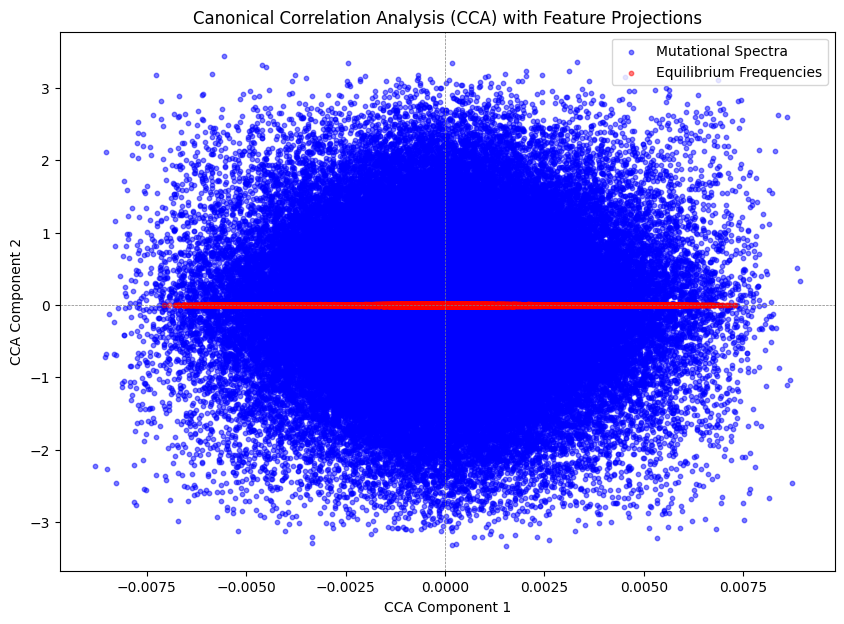

In [11]:
from sklearn.cross_decomposition import CCA

# Prepare data for CCA
X = random_ms_wide.values
Y = random_eq_freqs.loc[random_ms_wide.index.get_level_values('replica')].values

# Perform CCA
cca = CCA(n_components=2)
X_c, Y_c = cca.fit_transform(X, Y)

# Plot the results
plt.figure(figsize=(10, 7))
plt.scatter(X_c[:, 0], X_c[:, 1], alpha=0.5, label='Mutational Spectra', c='blue', s=10)
plt.scatter(Y_c[:, 0], Y_c[:, 1], alpha=0.5, label='Equilibrium Frequencies', c='red', s=10)

# # Add feature projections
# for i, (x_coef, y_coef) in enumerate(zip(cca.x_weights_[:, 0], cca.y_weights_[:, 0])):
#     plt.arrow(0, 0, x_coef, y_coef, color='green', alpha=0.5, head_width=0.02)
#     plt.text(x_coef * 1.1, y_coef * 1.1, random_ms_wide.columns[i], color='green', fontsize=8)

# Add axis labels and title
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('Canonical Correlation Analysis (CCA) with Feature Projections')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

In [14]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2)
pls.fit(X, Y)

# Важность признаков X для Y
print("Loadings X:", pls.x_loadings_)
print("Loadings Y:", pls.y_loadings_)

Loadings X: [[ 0.02028962 -0.01964589]
 [ 0.55526222 -0.43763488]
 [ 0.05328656  0.02556632]
 [-0.00655846  0.01981456]
 [ 0.0468294  -0.02323028]
 [ 0.43120358  0.55564335]
 [-0.55242675  0.43700204]
 [-0.03343261  0.02362785]
 [ 0.00409632  0.07192075]
 [-0.04965466 -0.04010264]
 [-0.4427545  -0.54999094]
 [ 0.00314535 -0.07503759]]
Loadings Y: [[ 9.80053002e-02 -8.06963213e-01]
 [ 8.03118185e-02 -7.23109342e-01]
 [-5.92618487e-01  4.73918503e-01]
 [-4.43595458e-05  4.21588506e-03]
 [ 7.48595509e-01  1.44277968e-01]
 [-7.50528557e-01 -7.51434394e-02]
 [-8.89223750e-03 -4.15879268e-02]
 [ 4.99884160e-01 -4.18748358e-01]
 [-7.44299746e-01 -5.40501609e-02]
 [-1.73123718e-01  7.86586168e-01]
 [ 3.28662455e-01  4.96246745e-01]
 [-4.06260280e-01  2.97420360e-01]
 [ 3.66369646e-01  4.69683902e-01]
 [ 3.33414539e-01  4.64838414e-01]
 [-3.91960814e-01 -4.60778080e-01]
 [ 1.23711274e-02  1.05425325e-01]
 [-8.08573571e-01 -6.99413757e-02]
 [ 7.34293866e-01 -1.10812766e-01]
 [-6.90152139e-02  7.

In [36]:
from sklearn.linear_model import LinearRegression
import numpy as np

X = random_ms_wide.values
Y = random_eq_freqs.loc[random_ms_wide.index.get_level_values('replica')].values


# Предположим, X и Y — это numpy массивы формы (N, m) и (N, k) соответственно
model = LinearRegression()
model.fit(X, Y)  # Обучаем модель

# Коэффициенты регрессии (влияние признаков X на Y)
# print("Коэффициенты (влияние X на Y):", model.coef_)
# print("Интерсепт:", model.intercept_)

# Предсказание Y по X
Y_pred = model.predict(X)

# Вычисление R^2
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

r2 = r2_score(Y, Y_pred)
rmse = np.sqrt(mean_squared_error(Y, Y_pred))
mae = mean_absolute_error(Y, Y_pred)
mape = mean_absolute_percentage_error(Y, Y_pred)

print("R^2:", r2)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)

R^2: 0.6784571129264688
RMSE: 0.02275810887748747
MAE: 0.012918144177742083
MAPE: 2.8058381986299468


In [50]:
mean_absolute_percentage_error(
    [1,2,3,4,5], [0.9,2.2,3.3,4.4,5.5], 
    sample_weight=[1,2,3,4,5],
)

0.10000000000000003

### PCA of amino acid freqs

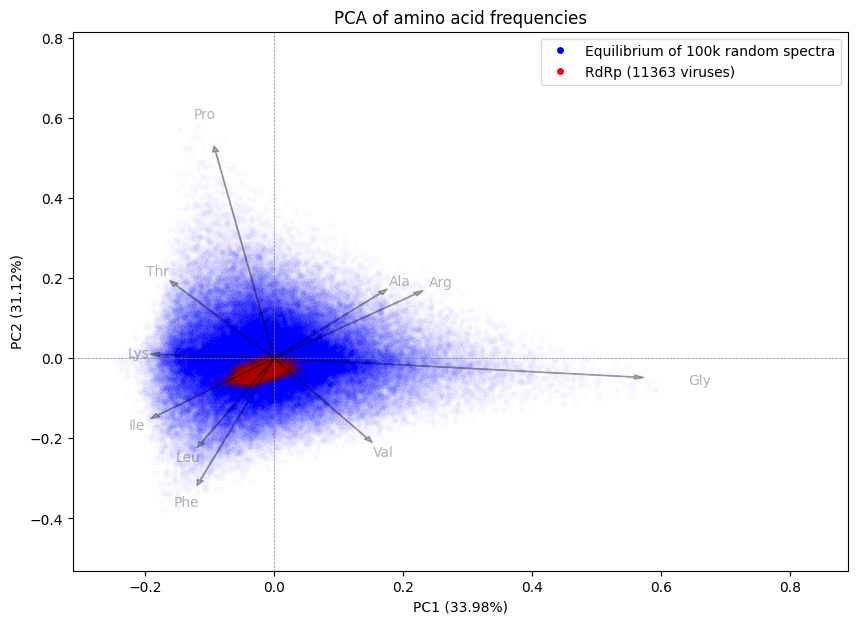

In [94]:
X = random_eq_freqs

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
pca_result_obs = pca.transform(obs_freqs_rdrp[X.columns])

# Calculate explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Create a biplot
plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.01, label='Samples', s=10, c='blue')
plt.scatter(pca_result_obs[:, 0], pca_result_obs[:, 1], alpha=0.01, label='Observed', s=10, c='red')

# Add feature vectors (show only the most valuable ones)
threshold = 0.2  # Adjust this threshold to filter vectors
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    magnitude = np.sqrt(comp1**2 + comp2**2)
    if magnitude > threshold:
        plt.arrow(0, 0, comp1/1.3, comp2/1.3, color='k', alpha=0.3, head_width=0.01)
        plt.text(comp1/1.1, comp2/1.1, X.columns[i], alpha=0.3, color='k', ha='center', va='center')

# Update axis labels with explained variance
plt.xlabel(f'PC1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({explained_variance[1]*100:.2f}%)')
plt.title('PCA of amino acid frequencies')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlim(min(pca_result[:, 0]) * 1.25, max(pca_result[:, 0]) * 1.5)
plt.ylim(min(pca_result[:, 1]) * 1.4, max(pca_result[:, 1]) * 1.4)
# custom legend with dots patches
plt.legend(
    handles=[
        Line2D([0], [0], color='w', marker='o', markerfacecolor='b', label='Equilibrium of 100k random spectra'),
        Line2D([0], [0], color='w', marker='o', markerfacecolor='r', label=f'RdRp ({len(pca_result_obs)} viruses)'),
    ],
    loc='upper right'
)
# plt.grid()
# plt.tight_layout()
plt.show()

In [116]:
random_eq_freqs.loc[pca_result[:, 0] > 0.4].index.to_series().sample(10)

replic
32570    32570
31048    31048
94524    94524
36963    36963
13852    13852
18807    18807
34615    34615
7805      7805
90593    90593
81621    81621
Name: replic, dtype: int64

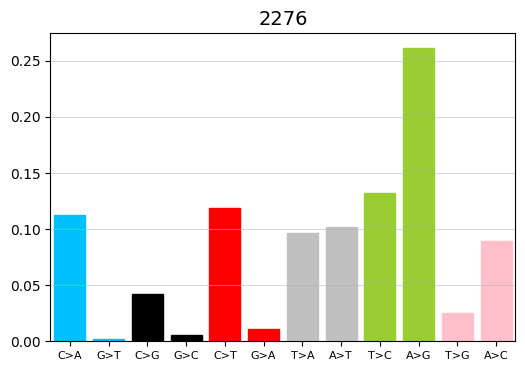

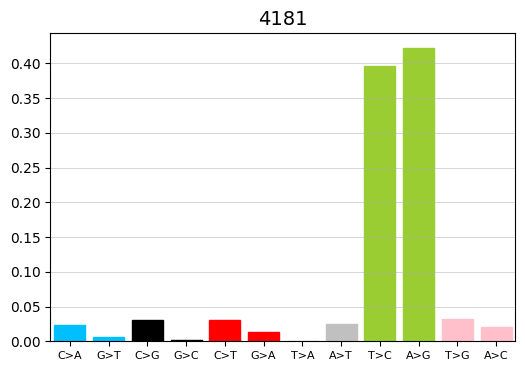

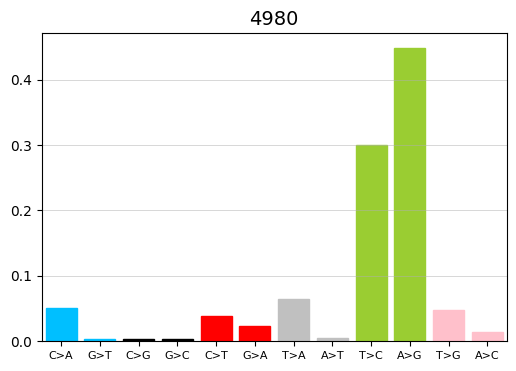

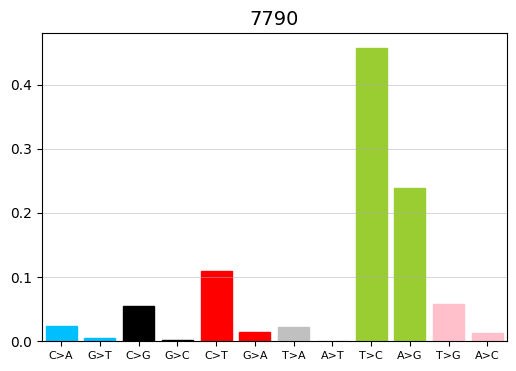

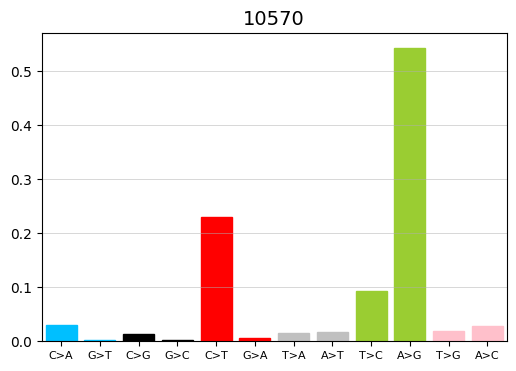

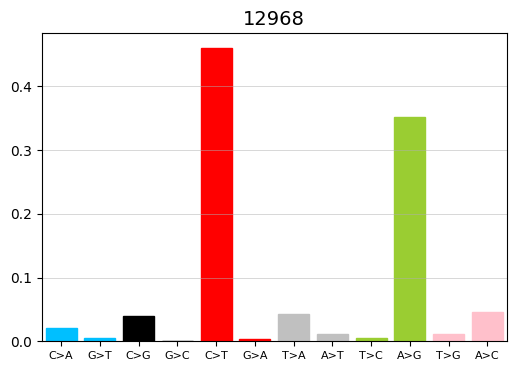

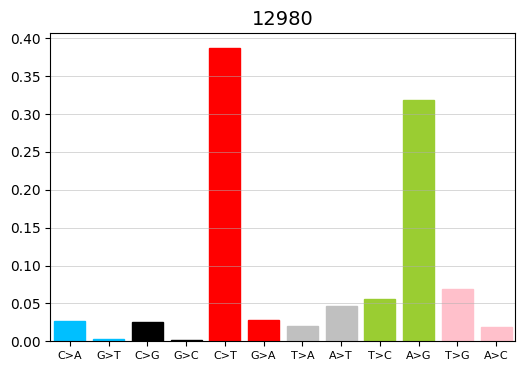

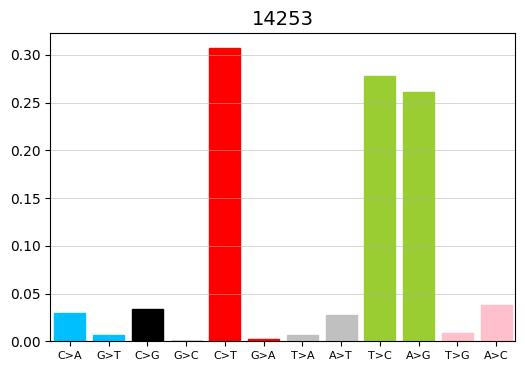

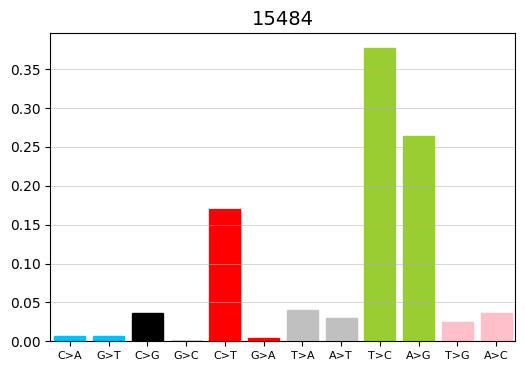

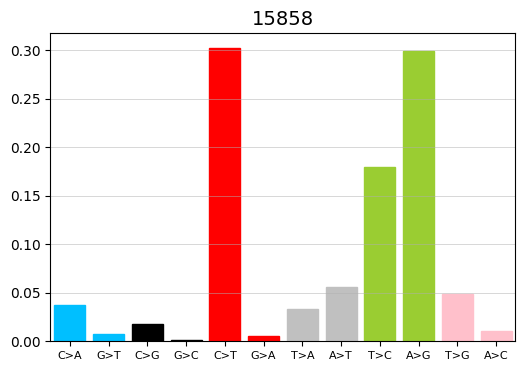

In [122]:
for r in random_eq_freqs.loc[pca_result[:, 0] > 0.5].index[:10]:
    plot_mutspec12(random_ms[random_ms.replica == r], title=r)

In [104]:
random_ms[random_ms.replica.isin(random_eq_freqs.loc[pca_result[:, 0] > 0.4].index)]

,replica,tstv_ratio,Mut,MutSpec
258,258,3.97049,A>C,0.007808
503,503,6.80292,A>C,0.014681
649,649,3.16097,A>C,0.001721
1298,1298,6.42561,A>C,0.038647
1328,1328,3.15215,A>C,0.005163
...,...,...,...,...
1196260,96260,6.39875,T>G,0.033343
1196291,96291,3.81626,T>G,0.040751
1196656,96656,4.25482,T>G,0.020634
1197473,97473,5.00504,T>G,0.028067


Text(0.5, 1.0, 'Loser-Gainer score distribution on random spectra')

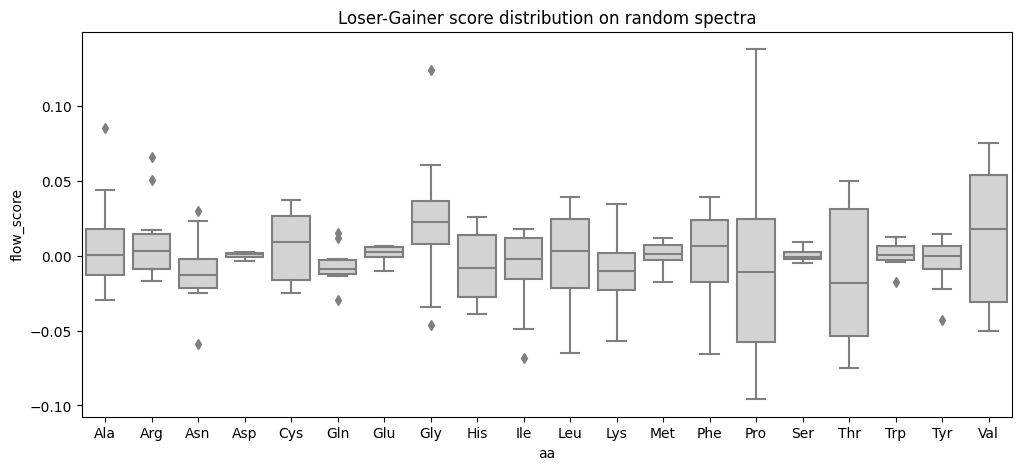

In [22]:
plt.figure(figsize=(12, 5))
ax = sns.boxplot(
    looser_gainer_score, 
    # order=looser_gainer_score.groupby('aa').flow_score.mean().sort_values(ascending=False).index,
    x='aa', y='flow_score', 
    color='lightgray',
    # palette='RedBlue3', 
#     edgecolor=".65"
)
ax.set_title('Loser-Gainer score distribution on random spectra')

<Axes: xlabel='aa', ylabel='eq_freq'>

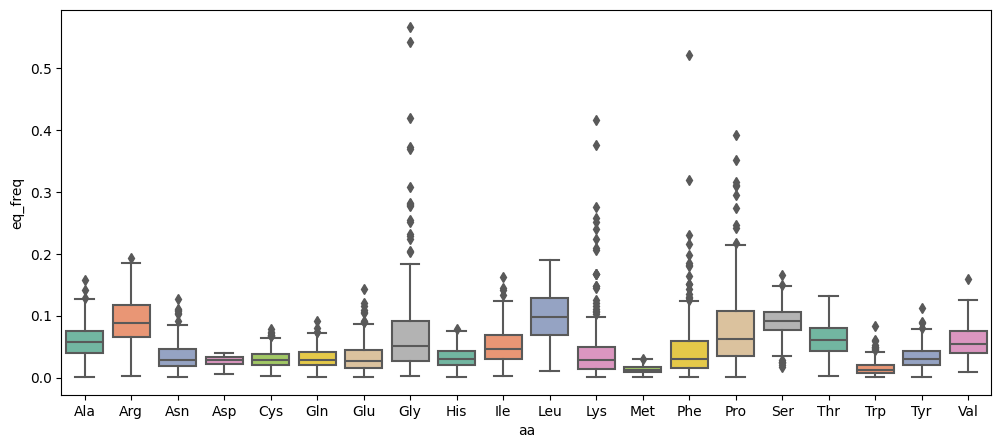

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(random_eq_freqs, x='aa', y='eq_freq',
            palette='Set2', order=sorted(random_eq_freqs.aa.unique()))

<Axes: xlabel='Mut', ylabel='MutSpec'>

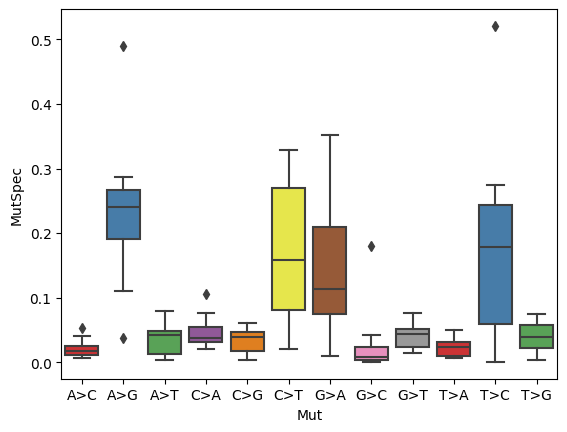

In [23]:
sns.boxplot(random_ms, x='Mut', y='MutSpec',
            palette='Set1', )

## Load RdRp amino acid freqs

In [ ]:
'../../Sars_Cov_2_MutSpec/Sars_Cov_2/data/Covid_ref.fasta'

In [ ]:
serratus_data = pd.read_csv('../data/FullData.txt', sep='\t')